In [3]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from scipy.stats import expon
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, recall_score, precision_score

def specificity_score(y_true, y_pred):
    """Calculate specificity (true negative rate)"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def train_randomized_inner_model(X_train, y_train, inner_folds, random_state, n_iter=1000):
    """Train model with inner CV grid search"""
    
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    
    # kernel lineal
    param_grid = {
        'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'kernel': ['linear']
    }
    
    svc1=SVC(random_state=random_state)
    grid_search = GridSearchCV(
        svc1,
        param_grid,
        cv=inner_folds,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    best_C = grid_search.best_params_['C']

    print("Initial best C from GridSearch:", best_C)

    param_distributions = {
        'C': expon(scale=best_C),
        'kernel': ['linear']
    }
    
    svc=SVC(random_state=random_state)
    random_search = RandomizedSearchCV(
        svc,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=inner_folds,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1,
        random_state=random_state
    )

    random_search.fit(X_train, y_train)
    
    print("Final best params from RandomizedSearch:")
    print(random_search.best_params_)
    print("Final best score:", random_search.best_score_)

    return random_search

def plot_ROC_curve(all_y_true, all_y_proba, filename='roc_curve.png'):
    """Generate and save ROC curve"""

    fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.close()

def plot_confusion_matrix(y_true, y_pred, filename='confusion_matrix.png'):

    cf_matrix = confusion_matrix(y_true, y_pred, normalize=("true"))
    cf_matrix_v = confusion_matrix(y_true, y_pred)
    
    # Define a color map for the heatmap
    cmap = sns.color_palette("Blues", as_cmap=True)
    
    plt.figure(figsize = (6,6))
    heatmap = sns.heatmap(cf_matrix, annot=False, cmap=cmap, fmt='d', xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'], square=True, cbar=True)
    # heatmap = sns.heatmap(data, annot=False, fmt='d', cmap=cmap)
    
    # Calculate and display percentages
    for i in range(len(cf_matrix)):
        for j in range(len(cf_matrix[i])):
            text = f"{cf_matrix[i][j]*100: 0.2f}% ({cf_matrix_v[i][j]})"
            
            # Calculate the background color at the center of the cell
            cell_bg_color = np.mean(cmap(cf_matrix[i][j]))
            print(i,j, cell_bg_color)
            # Choose a text color based on the background color
            text_color = 'black' if cell_bg_color > 0.7 else 'white'
                    
            heatmap.text(j + 0.5, i + 0.5, text, ha='center', va='center', color=text_color)

    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.title("Confusion Matrix")
    plt.tight_layout()

    plt.savefig(filename, dpi=300)

    
    return cf_matrix

def plot_probability_density(y_true, y_proba, filename='probability_density.png'):
    """
    Plot density distribution of predicted probabilities for each class
    
    Parameters:
    -----------
    y_true : array-like
        True labels (0=HC, 1=PD)
    y_proba : array-like
        Predicted probabilities for class 1 (PD)
    save_path : str
        Path to save the plot
    """
    # Create DataFrame for plotting
    df = pd.DataFrame({
        'Probability': y_proba,
        'Group': ['HC' if label == 0 else 'PD' for label in y_true]
    })
    
    # Define colors (Soft blue shades)
    blues = sns.color_palette("Blues", n_colors=6)
    colors = [blues[1], blues[4]]  # light blue for HC, dark blue for PD

    # Create figure with two subplots: Boxplot (top) and Density plot (bottom)
    fig, axes = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [1, 4]}, figsize=(6, 6), sharex=True)

    # Boxplot (Top)
    sns.boxplot(x="Probability", y="Group", data=df, dodge=False, palette=colors, ax=axes[0])
    axes[0].set_xlabel("")
    axes[0].set_ylabel("")
    axes[0].set_yticks([])
    axes[0].set_title("Predicted Probability Distribution")

    sns.histplot(data=df, x="Probability", hue="Group", kde=True, palette=colors, stat="density", bins=20, ax=axes[1], legend=True)
    
    axes[1].set_xlabel("Predicted Probability")
    legend_handles = [
        Patch(color=colors[0], label='HC'),
        Patch(color=colors[1], label='PD')
    ]
    axes[1].legend(handles=legend_handles)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()

def run_nested_svm_cv(fold_dict, features_df, random_state=42, type='_MOTOR_LIBRE.wav'):
    """
        Perform nested CV SVM classification with predefined folds
        
        Parameters:
        -----------
        fold_dict : dict
            Output from generate_nested_cv_folds()
        features_df : pd.DataFrame
            DataFrame with features (index=filename, columns=features)
        random_state : int
            Random seed for reproducibility
            
        Returns:
        --------
        tuple: (results_df, all_y_true, all_y_pred, all_y_proba)
    """

    C = []
    results = []
    best_scores = []
    test_predictions = []
    all_scores = []

    for outer_fold, fold_info in fold_dict.items():
        test_ids = [id_ + type for id_ in fold_info["test"].keys()]
        y_test = list(fold_info["test"].values())

        train_labels_dict = {}
        for inner in fold_info["inner"].values():
            train_labels_dict.update(inner["train"])
            train_labels_dict.update(inner["val"])
        train_ids = [id_ + type for id_ in train_labels_dict.keys()]
        y_train = list(train_labels_dict.values())

        print(train_ids)
        X_train = features_df.loc[train_ids].values
        X_test = features_df.loc[test_ids].values

        inner_folds = []
        for inner_num, inner in fold_info["inner"].items():
            inner_train_ids = [id_ + type for id_ in inner["train"].keys()]
            val_ids = [id_ + type for id_ in inner["val"].keys()]
            train_idx = [i for i, id_ in enumerate(train_ids) if id_ in inner_train_ids]
            val_idx = [i for i, id_ in enumerate(train_ids) if id_ in val_ids]
            inner_folds.append((train_idx, val_idx))

        model = train_randomized_inner_model(X_train, y_train, inner_folds, random_state)

        print("--------------- Best Params ------------------")
        print(model.best_params_)
        print(model.best_score_)
        C.append(model.best_params_['C'])
        best_scores.append(model.best_score_)
    
    print(C)
    Copt=np.median(C)
    print(Copt)
    print('-----------------------------------------')
    print()

    for idx, (outer_fold, fold_info) in enumerate(fold_dict.items()):
        test_ids = [id_ + type for id_ in fold_info["test"].keys()]
        y_test = list(fold_info["test"].values())

        train_labels_dict = {}
        for inner in fold_info["inner"].values():
            train_labels_dict.update(inner["train"])
            train_labels_dict.update(inner["val"])
        train_ids = [id_ + type for id_ in train_labels_dict.keys()]
        y_train = list(train_labels_dict.values())

        X_train = features_df.loc[train_ids].values
        X_test = features_df.loc[test_ids].values

        scaler=StandardScaler()
        X_train=scaler.fit_transform(X_train)
        X_test=scaler.transform(X_test)

        model = SVC(C=Copt, kernel="linear", random_state=random_state, probability=True)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        train_decision_scores = model.decision_function(X_train)
        test_decision_scores = model.decision_function(X_test)

        for id_, score in zip(train_ids, train_decision_scores):
            all_scores.append({
                'id': id_,
                'score': score,
                'outer_fold': outer_fold,
                'set_type': 'train'
            })

        for id_, score in zip(test_ids, test_decision_scores):
            all_scores.append({
                'id': id_,
                'score': score,
                'outer_fold': outer_fold,
                'set_type': 'test'
            })

        acc = accuracy_score(y_test, y_pred)
        sens = recall_score(y_test, y_pred)
        spec = specificity_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        results.append({
            'outer_fold': outer_fold,
            'accuracy': acc,
            'sensitivity': sens,
            'specificity': spec,
            'f1': f1,
            'precision': prec,
            'confusion_matrix': cm,
            'C': C[idx],
        })

        for sample_id, yt, yp, yp_prob, sc in zip(test_ids, y_test, y_pred, y_proba, test_decision_scores):
            test_predictions.append({
                'id': sample_id,
                'y_true': yt,
                'y_pred': yp,
                'y_proba': yp_prob,
                'score': sc,
                'outer_fold': outer_fold
            })

        print(f"\nFold {outer_fold} Results:")
        print(f"Train set size: {len(y_train)}")
        print(f"Test set size: {len(y_test)}")
        print(f"Accuracy: {acc:.3f}")
        print(f"Sensitivity: {sens:.3f}")
        print(f"Specificity: {spec:.3f}")

    return results, test_predictions, all_scores

def run_late_fusion(fold_dict, scores_df, random_state=42, type='_MOTOR_LIBRE.wav'):
    """
    Perform late fusion using pre-merged scores from multiple modalities
    
    Parameters:
    -----------
    fold_dict : dict
        Dictionary containing the nested CV fold information
    scores_df : pd.DataFrame
        DataFrame containing merged scores from all modalities with columns:
        ['id', 'outer_fold', 'set_type', 'artic_score', 'phon_score', 'pros_score', ...]
    random_state : int
        Random seed for reproducibility
    type : str
        Suffix to add to IDs
        
    Returns:
    --------
    tuple: (results, test_predictions, inner_val_predictions)
    """
    C, best_scores = [], []
    results, test_predictions = [], []
    all_scores = []

    # Get the score columns (all columns that end with '_score')
    score_columns = [col for col in scores_df.columns if col.endswith('_score')]
    
    for outer_fold, fold_info in fold_dict.items():
        outer_fold = int(outer_fold)
        test_ids = [id_ + type for id_ in fold_info["test"].keys()]
        y_test = list(fold_info["test"].values())

        # Get training IDs and labels
        train_labels_dict = {}
        for inner in fold_info["inner"].values():
            train_labels_dict.update(inner["train"])
            train_labels_dict.update(inner["val"])
        train_ids = [id_ + type for id_ in train_labels_dict.keys()]
        y_train = list(train_labels_dict.values())
        
        # Get training and test data from scores_df
        X_train = scores_df[(scores_df['id'].isin(train_ids)) & 
                           (scores_df['outer_fold'] == outer_fold) &
                           (scores_df['set_type'] == 'train')][score_columns].values
        
        X_test = scores_df[(scores_df['id'].isin(test_ids)) & 
                          (scores_df['outer_fold'] == outer_fold) &
                          (scores_df['set_type'] == 'test')][score_columns].values

        # Create inner folds for hyperparameter tuning
        inner_folds = []
        for inner in fold_info["inner"].values():
            inner_train_ids = [id_ + type for id_ in inner["train"].keys()]
            val_ids = [id_ + type for id_ in inner["val"].keys()]
            train_idx = [i for i, id_ in enumerate(train_ids) if id_ in inner_train_ids]
            val_idx = [i for i, id_ in enumerate(train_ids) if id_ in val_ids]
            inner_folds.append((train_idx, val_idx))

        model = train_randomized_inner_model(X_train, y_train, inner_folds, random_state)

        print("--------------- Best Params ------------------")
        print(model.best_params_)
        print(model.best_score_)
        C.append(model.best_params_['C'])
        best_scores.append(model.best_score_)

    # Use median of best parameters from all outer folds
    Copt = np.median(C)
    print(f"Final SVM Params - C: {Copt}")
    print('-----------------------------------------\n')

    for idx, (outer_fold, fold_info) in enumerate(fold_dict.items()):
        outer_fold = int(outer_fold)
        test_ids = [id_ + type for id_ in fold_info["test"].keys()]
        y_test = list(fold_info["test"].values())

        train_labels_dict = {}
        for inner in fold_info["inner"].values():
            train_labels_dict.update(inner["train"])
            train_labels_dict.update(inner["val"])
        train_ids = [id_ + type for id_ in train_labels_dict.keys()]
        y_train = list(train_labels_dict.values())

        # Get data for final evaluation
        X_train = scores_df[(scores_df['id'].isin(train_ids)) & 
                          (scores_df['outer_fold'] == outer_fold) &
                          (scores_df['set_type'] == 'train')][score_columns].values
        
        X_test = scores_df[(scores_df['id'].isin(test_ids)) & 
                         (scores_df['outer_fold'] == outer_fold) &
                         (scores_df['set_type'] == 'test')][score_columns].values
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = SVC(C=Copt, kernel="linear", random_state=random_state, probability=True)
        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]

        train_decision_scores = model.decision_function(X_train)
        test_decision_scores = model.decision_function(X_test)

        for id_, score in zip(train_ids, train_decision_scores):
            all_scores.append({
                'id': id_,
                'score': score,
                'outer_fold': outer_fold,
                'set_type': 'train'
            })

        for id_, score in zip(test_ids, test_decision_scores):
            all_scores.append({
                'id': id_,
                'score': score,
                'outer_fold': outer_fold,
                'set_type': 'test'
            })

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        sens = recall_score(y_test, y_pred)
        spec = specificity_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        results.append({
            'outer_fold': outer_fold,
            'accuracy': acc,
            'sensitivity': sens,
            'specificity': spec,
            'f1': f1,
            'precision': prec,
            'confusion_matrix': cm,
            'C': C[idx],
        })

        for sample_id, yt, yp, yp_prob, sc in zip(test_ids, y_test, y_pred, y_proba, test_decision_scores):
            test_predictions.append({
                'id': sample_id,
                'y_true': yt,
                'y_pred': yp,
                'y_proba': yp_prob,
                'score': sc,
                'outer_fold': outer_fold
            })

        print(f"\nFold {outer_fold} Results:")
        print(f"Train set size: {len(y_train)}")
        print(f"Test set size: {len(y_test)}")
        print(f"Accuracy: {acc:.3f}")
        print(f"Sensitivity: {sens:.3f}")
        print(f"Specificity: {spec:.3f}")

    return results, test_predictions, all_scores

# Load all folds
folds_paths = {
    "PD_vs_HC": "folds/PD_vs_HC_folds.json",
    "CTR_DCL_vs_Park_DCL": "folds/CTR_DCL_vs_Park_DCL_folds.json",
    "CTR_noDCL_vs_Park_noDCL": "folds/CTR_noDCL_vs_Park_noDCL_folds.json",
    "Park_noDCL_vs_Park_DCL": "folds/Park_noDCL_vs_Park_DCL_folds.json",
}

folds_data = {}
for name, path in folds_paths.items():
    with open(path, "r") as f:
        folds_data[name] = json.load(f)

# Load feature sets
features_dict = {
    "articulation": pd.read_csv('features_motor_libre/articulationfeatures_ML.csv').set_index('id'),
    "prosody": pd.read_csv('features_motor_libre/prosodyfeatures_ML.csv').set_index('id'),
    "phonological": pd.read_csv('features_motor_libre/phonologicalfeatures_ML.csv').set_index('id')
}

# Motor libre

In [2]:
for fold_name, fold_data in folds_data.items():
    print(f"Running experiments for: {fold_name}")
    
    # Create directory for this fold if it doesn't exist
    os.makedirs(f"results_linear/results_motor_libre/{fold_name}", exist_ok=True)

    for feat_type, feat_df in features_dict.items():
        print(f" - Feature set: {feat_type}")
        
        results, test_predictions, scores = run_nested_svm_cv(fold_data, feat_df)

        results_df = pd.DataFrame(results)
        test_predictions_df = pd.DataFrame(test_predictions)
        scored_df = pd.DataFrame(scores)

        # Save results
        results_df.to_csv(f"results_linear/results_motor_libre/{fold_name}/{feat_type}_results.csv", index=False)
        test_predictions_df.to_csv(f"results_linear/results_motor_libre/{fold_name}/{feat_type}_test_predictions.csv", index=False)
        scored_df.to_csv(f"results_linear/results_motor_libre/{fold_name}/{feat_type}_scores.csv", index=False)

        all_y_true = [x['y_true'] for x in test_predictions]
        all_y_proba = [x['y_proba'] for x in test_predictions]
        all_y_pred = [x['y_pred'] for x in test_predictions]

        os.makedirs(f"results_linear/results_motor_libre/{fold_name}/plots/", exist_ok=True)

        plot_ROC_curve(all_y_true, all_y_proba, f'results_linear/results_motor_libre/{fold_name}/plots/roc_curve_{feat_type}.png')
        plot_confusion_matrix(all_y_true, all_y_pred, f'results_linear/results_motor_libre/{fold_name}/plots/confusion_matrix_{feat_type}.png')
        plot_probability_density(all_y_true, all_y_proba, f'results_linear/results_motor_libre/{fold_name}/plots/probability_density_{feat_type}.png')

NameError: name 'folds_data' is not defined

In [8]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    return tn / (tn + fp) if (tn + fp) > 0 else 0

for fold_name, fold_data in folds_data.items():
    print(f"Motor experiments for: {fold_name}")

    for feat_type, feat_df in features_dict.items():
        print(f" - Feature set: {feat_type}")

        results_df = pd.read_csv(f"results_linear/results_motor_libre/{fold_name}/{feat_type}_results.csv")
        results_test_predictions_df = pd.read_csv(f"results_linear/results_motor_libre/{fold_name}/{feat_type}_test_predictions.csv")

        y_test = results_test_predictions_df['y_true']
        y_pred = results_test_predictions_df['y_pred']
        y_prob = results_test_predictions_df['score']

        acc = accuracy_score(y_test, y_pred)
        sens = recall_score(y_test, y_pred)
        spec = specificity_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)

        print(f"accuracy: {100*acc:.1f}")
        print(f"sensitivity: {100*sens:.1f}")
        print(f"specificity: {100*spec:.1f}")
        print(f"f1: {100*f1:.1f}")
        print(f"AUC: {auc:.2f}")

        # for metric in ['accuracy', 'sensitivity', 'specificity', 'f1']:
        #     acc = accuracy_score(y_test, y_pred)
        #     sens = recall_score(y_test, y_pred)
        #     spec = specificity_score(y_test, y_pred)
        #     f1 = f1_score(y_test, y_pred)

        #     mean_val = results_df[metric].mean()
        #     std_val = results_df[metric].std()
        #     print(f"{metric.capitalize()}: {100*mean_val:.1f} ± {100*std_val:.1f}")

        print()

Motor experiments for: PD_vs_HC
 - Feature set: articulation
accuracy: 70.9
sensitivity: 65.0
specificity: 76.9
f1: 69.3
AUC: 0.77

 - Feature set: prosody
accuracy: 63.3
sensitivity: 60.0
specificity: 66.7
f1: 62.3
AUC: 0.70

 - Feature set: phonological
accuracy: 70.9
sensitivity: 72.5
specificity: 69.2
f1: 71.6
AUC: 0.75

Motor experiments for: CTR_DCL_vs_Park_DCL
 - Feature set: articulation
accuracy: 68.8
sensitivity: 56.2
specificity: 81.2
f1: 64.3
AUC: 0.87

 - Feature set: prosody
accuracy: 71.9
sensitivity: 68.8
specificity: 75.0
f1: 71.0
AUC: 0.74

 - Feature set: phonological
accuracy: 87.5
sensitivity: 81.2
specificity: 93.8
f1: 86.7
AUC: 0.95

Motor experiments for: CTR_noDCL_vs_Park_noDCL
 - Feature set: articulation
accuracy: 70.2
sensitivity: 58.3
specificity: 82.6
f1: 66.7
AUC: 0.68

 - Feature set: prosody
accuracy: 59.6
sensitivity: 62.5
specificity: 56.5
f1: 61.2
AUC: 0.62

 - Feature set: phonological
accuracy: 66.0
sensitivity: 62.5
specificity: 69.6
f1: 65.2
AUC:

## Early fusion


Running early fusion experiments for: PD_vs_HC
['C001R_AJZP_MOTOR_LIBRE.wav', 'C004_MLQ_MOTOR_LIBRE.wav', 'C005_ABV_MOTOR_LIBRE.wav', 'C006_JJHN_MOTOR_LIBRE.wav', 'C010_MVQG_MOTOR_LIBRE.wav', 'C011_JOMG_MOTOR_LIBRE.wav', 'C012_CTRE_MOTOR_LIBRE.wav', 'C013_JIHL_MOTOR_LIBRE.wav', 'C014_MEMT_MOTOR_LIBRE.wav', 'C015_HJOL_MOTOR_LIBRE.wav', 'C016_EALE_MOTOR_LIBRE.wav', 'C017_JMLC_MOTOR_LIBRE.wav', 'C021_GDGR_MOTOR_LIBRE.wav', 'C026_JEPM_MOTOR_LIBRE.wav', 'C031_RALR_MOTOR_LIBRE.wav', 'C034_ADV_MOTOR_LIBRE.wav', 'C040_NELC_MOTOR_LIBRE.wav', 'C042_MHL_MOTOR_LIBRE.wav', 'C045_LARE_MOTOR_LIBRE.wav', 'C046_GGC_MOTOR_LIBRE.wav', 'C047_ISV_MOTOR_LIBRE.wav', 'C049_MLLR_MOTOR_LIBRE.wav', 'C050_BOLR_MOTOR_LIBRE.wav', 'P002_HJTC_MOTOR_LIBRE.wav', 'P003_MBCB_MOTOR_LIBRE.wav', 'P004_GGN_MOTOR_LIBRE.wav', 'P006_FAGP_MOTOR_LIBRE.wav', 'P007_RAGP_MOTOR_LIBRE.wav', 'P012_CAMM_MOTOR_LIBRE.wav', 'P013_JIRB_MOTOR_LIBRE.wav', 'P014_ACE_MOTOR_LIBRE.wav', 'P015_FAOH_MOTOR_LIBRE.wav', 'P018_MMCM_MOTOR_LIBRE.wav', '

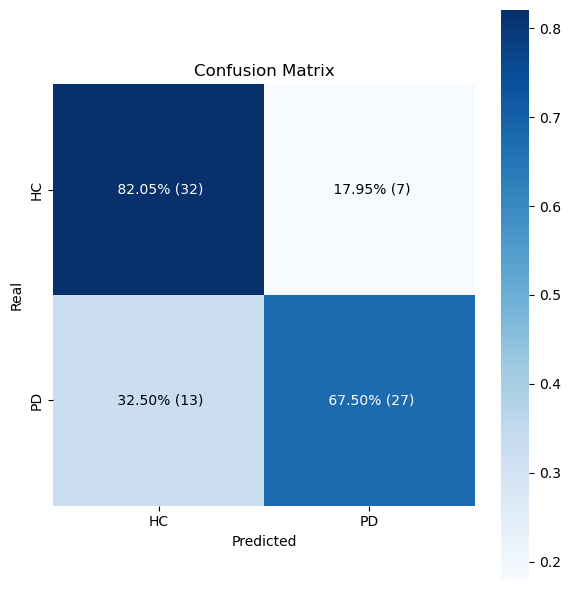

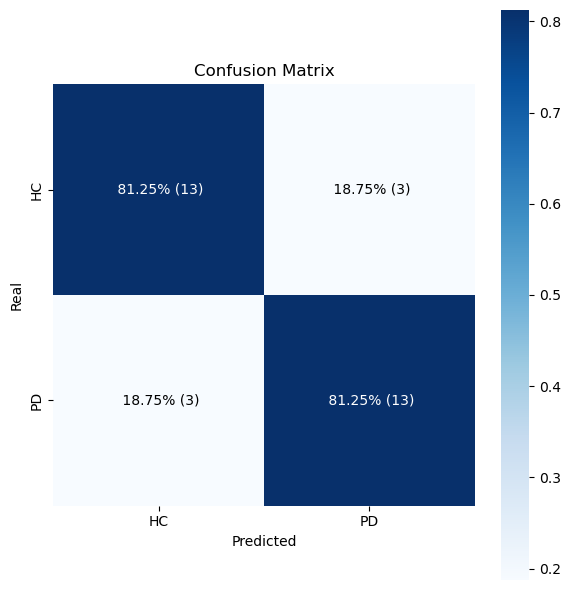

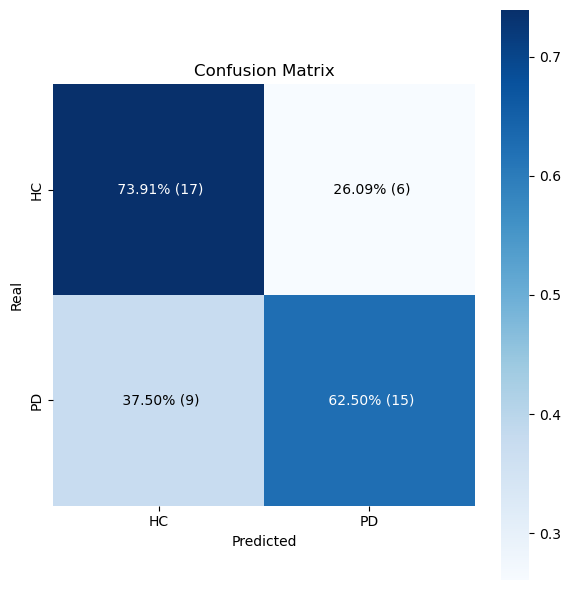

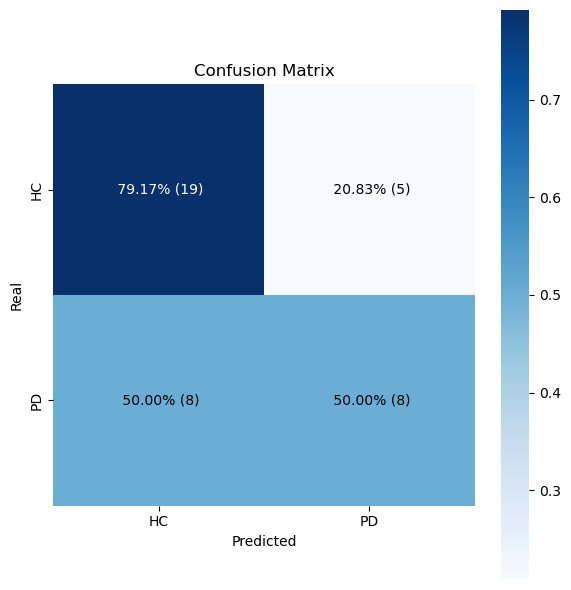

In [37]:
# Create early fusion dataframe by joining on index (id)
features_early_fusion = pd.concat(features_dict.values(), axis=1)

# Run experiments
for fold_name, fold_data in folds_data.items():
    print(f"\nRunning early fusion experiments for: {fold_name}")
    
    # Run nested CV with the concatenated features
    results, test_predictions, scores = run_nested_svm_cv(fold_data, features_early_fusion)

    results_df = pd.DataFrame(results)
    test_predictions_df = pd.DataFrame(test_predictions)
    scored_df = pd.DataFrame(scores)

    # Save results
    results_df.to_csv(f"results_linear/results_motor_libre/{fold_name}/earlyfusion_results.csv", index=False)
    test_predictions_df.to_csv(f"results_linear/results_motor_libre/{fold_name}/earlyfusion_test_predictions.csv", index=False)
    scored_df.to_csv(f"results_linear/results_motor_libre/{fold_name}/earlyfusion_scores.csv", index=False)

    all_y_true = [x['y_true'] for x in test_predictions]
    all_y_proba = [x['y_proba'] for x in test_predictions]
    all_y_pred = [x['y_pred'] for x in test_predictions]

    os.makedirs(f"results_linear/results_motor_libre/{fold_name}/plots/", exist_ok=True)

    plot_ROC_curve(all_y_true, all_y_proba, f'results_linear/results_motor_libre/{fold_name}/plots/roc_curve_early_fusion.png')
    plot_confusion_matrix(all_y_true, all_y_pred, f'results_linear/results_motor_libre/{fold_name}/plots/confusion_matrix_early_fusion.png')
    plot_probability_density(all_y_true, all_y_proba, f'results_linear/results_motor_libre/{fold_name}/plots/probability_density_early_fusion.png')

In [9]:
for fold_name, fold_data in folds_data.items():
    print(f"Reading experiments for early fusion: {fold_name}")

    # Save results
    results_df = pd.read_csv(f"results_linear/results_motor_libre/{fold_name}/earlyfusion_results.csv")

    results_test_predictions_df = pd.read_csv(f"results_linear/results_motor_libre/{fold_name}/earlyfusion_test_predictions.csv")

    y_test = results_test_predictions_df['y_true']
    y_pred = results_test_predictions_df['y_pred']
    y_prob = results_test_predictions_df['score']

    acc = accuracy_score(y_test, y_pred)
    sens = recall_score(y_test, y_pred)
    spec = specificity_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"accuracy: {100*acc:.1f}")
    print(f"sensitivity: {100*sens:.1f}")
    print(f"specificity: {100*spec:.1f}")
    print(f"f1: {100*f1:.1f}")
    print(f"AUC: {auc:.2f}")
    
    # for metric in ['accuracy', 'sensitivity', 'specificity', 'f1']:
    #     mean_val = results_df[metric].mean()
    #     std_val = results_df[metric].std()
    #     print(f"{metric.capitalize()}: {100*mean_val:.1f} ± {100*std_val:.1f}")
    
    print()

Reading experiments for early fusion: PD_vs_HC
accuracy: 74.7
sensitivity: 67.5
specificity: 82.1
f1: 73.0
AUC: 0.79

Reading experiments for early fusion: CTR_DCL_vs_Park_DCL
accuracy: 81.2
sensitivity: 81.2
specificity: 81.2
f1: 81.2
AUC: 0.89

Reading experiments for early fusion: CTR_noDCL_vs_Park_noDCL
accuracy: 68.1
sensitivity: 62.5
specificity: 73.9
f1: 66.7
AUC: 0.65

Reading experiments for early fusion: Park_noDCL_vs_Park_DCL
accuracy: 67.5
sensitivity: 50.0
specificity: 79.2
f1: 55.2
AUC: 0.74



## Late fusion

Running experiments for: PD_vs_HC
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Initial best C from GridSearch: 0.01
Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
Final best params from RandomizedSearch:
{'C': 0.013167456935454494, 'kernel': 'linear'}
Final best score: 0.8572916666666667
--------------- Best Params ------------------
{'C': 0.013167456935454494, 'kernel': 'linear'}
0.8572916666666667
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Initial best C from GridSearch: 0.1
Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
Final best params from RandomizedSearch:
{'C': 0.09129425537759533, 'kernel': 'linear'}
Final best score: 0.90625
--------------- Best Params ------------------
{'C': 0.09129425537759533, 'kernel': 'linear'}
0.90625
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Initial best C from GridSearch: 0.1
Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
Final best params from Ran

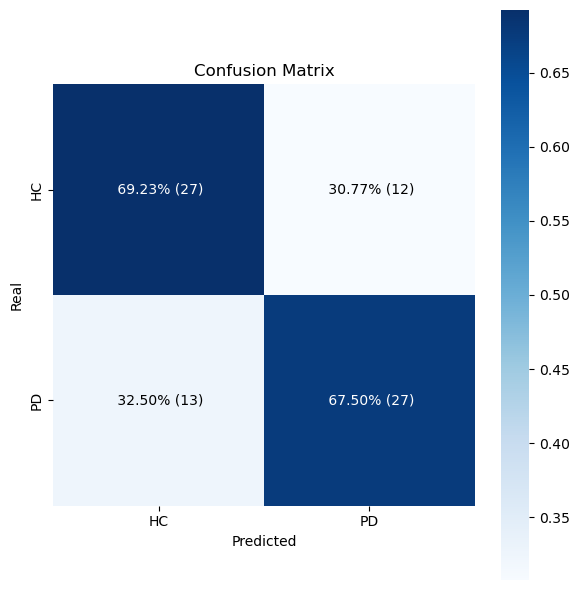

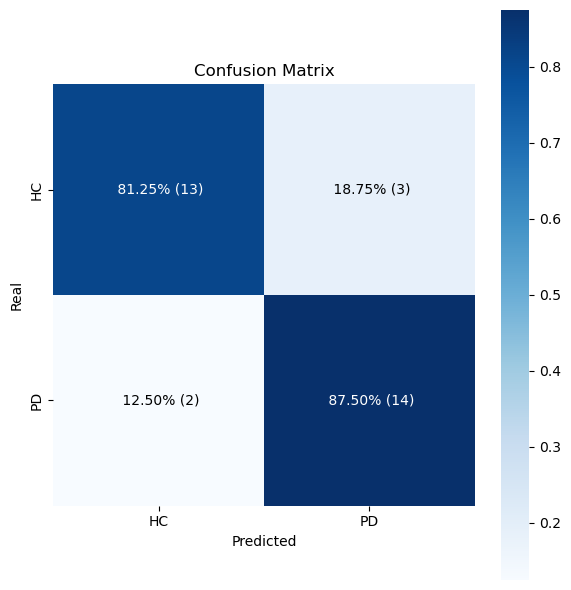

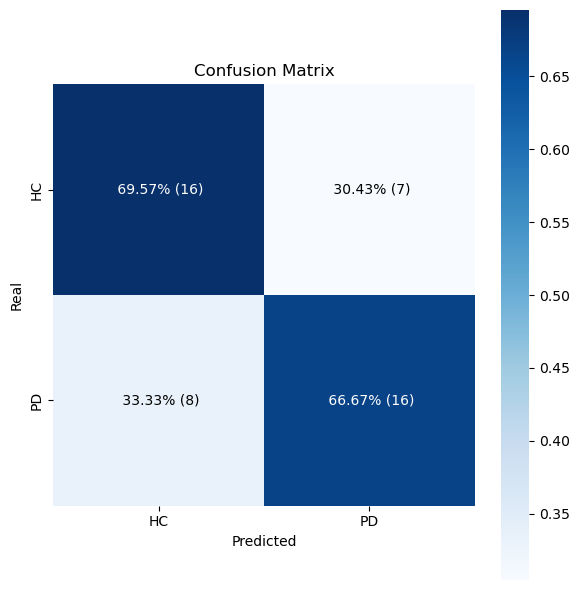

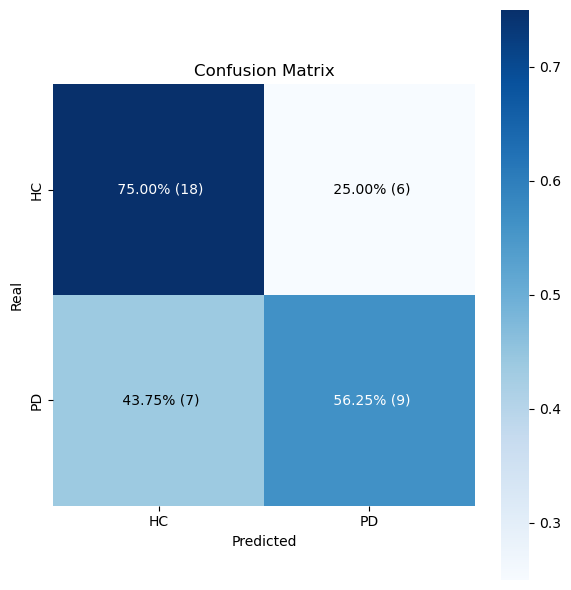

In [39]:
for fold_name, fold_data in folds_data.items():
    print(f"Running experiments for: {fold_name}")

    scores_artic_df = pd.read_csv(f"results_linear/results_motor_libre/{fold_name}/articulation_scores.csv")
    scores_phon_df = pd.read_csv(f"results_linear/results_motor_libre/{fold_name}/phonological_scores.csv")
    scores_pros_df = pd.read_csv(f"results_linear/results_motor_libre/{fold_name}/prosody_scores.csv")
        
    # Select and rename score columns while keeping id, outer_fold, and set_type
    artic_scores = scores_artic_df[['id', 'outer_fold', 'set_type', 'score']].rename(columns={'score': 'artic_score'})
    phon_scores = scores_phon_df[['id', 'outer_fold', 'set_type', 'score']].rename(columns={'score': 'phon_score'})
    pros_scores = scores_pros_df[['id', 'outer_fold', 'set_type', 'score']].rename(columns={'score': 'pros_score'})

    # Merge the dataframes
    merged_scores_df = artic_scores.merge(
        phon_scores, 
        on=['id', 'outer_fold', 'set_type']
    ).merge(
        pros_scores,
        on=['id', 'outer_fold', 'set_type']
    )

    results, test_predictions, scores = run_late_fusion(fold_data, merged_scores_df)

    results_df = pd.DataFrame(results)
    test_predictions_df = pd.DataFrame(test_predictions)
    scored_df = pd.DataFrame(scores)

    # Save results
    results_df.to_csv(f"results_linear/results_motor_libre/{fold_name}/latefusion_results.csv", index=False)
    test_predictions_df.to_csv(f"results_linear/results_motor_libre/{fold_name}/latefusion_test_predictions.csv", index=False)
    scored_df.to_csv(f"results_linear/results_motor_libre/{fold_name}/latefusion_scores.csv", index=False)

    all_y_true = [x['y_true'] for x in test_predictions]
    all_y_proba = [x['y_proba'] for x in test_predictions]
    all_y_pred = [x['y_pred'] for x in test_predictions]

    os.makedirs(f"results_linear/results_motor_libre/{fold_name}/plots/", exist_ok=True)

    plot_ROC_curve(all_y_true, all_y_proba, f'results_linear/results_motor_libre/{fold_name}/plots/roc_curve_late_fusion.png')
    plot_confusion_matrix(all_y_true, all_y_pred, f'results_linear/results_motor_libre/{fold_name}/plots/confusion_matrix_late_fusion.png')
    plot_probability_density(all_y_true, all_y_proba, f'results_linear/results_motor_libre/{fold_name}/plots/probability_density_late_fusion.png')

In [10]:
for fold_name, fold_data in folds_data.items():
    print(f"Libre experiments for late fusion: {fold_name}")

    results_df = pd.read_csv(f"results_linear/results_motor_libre/{fold_name}/latefusion_results.csv")
    
    results_test_predictions_df = pd.read_csv(f"results_linear/results_motor_libre/{fold_name}/latefusion_test_predictions.csv")

    y_test = results_test_predictions_df['y_true']
    y_pred = results_test_predictions_df['y_pred']
    y_prob = results_test_predictions_df['score']

    acc = accuracy_score(y_test, y_pred)
    sens = recall_score(y_test, y_pred)
    spec = specificity_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"accuracy: {100*acc:.1f}")
    print(f"sensitivity: {100*sens:.1f}")
    print(f"specificity: {100*spec:.1f}")
    print(f"f1: {100*f1:.1f}")
    print(f"AUC: {auc:.2f}")

    # for metric in ['accuracy', 'sensitivity', 'specificity', 'f1']:
    #     mean_val = results_df[metric].mean()
    #     std_val = results_df[metric].std()
    #     print(f"{metric.capitalize()}: {100*mean_val:.1f} ± {100*std_val:.1f}")        
    
    print()

Libre experiments for late fusion: PD_vs_HC
accuracy: 68.4
sensitivity: 67.5
specificity: 69.2
f1: 68.4
AUC: 0.77

Libre experiments for late fusion: CTR_DCL_vs_Park_DCL
accuracy: 84.4
sensitivity: 87.5
specificity: 81.2
f1: 84.8
AUC: 0.91

Libre experiments for late fusion: CTR_noDCL_vs_Park_noDCL
accuracy: 68.1
sensitivity: 66.7
specificity: 69.6
f1: 68.1
AUC: 0.71

Libre experiments for late fusion: Park_noDCL_vs_Park_DCL
accuracy: 67.5
sensitivity: 56.2
specificity: 75.0
f1: 58.1
AUC: 0.73



# Reading

Running experiments for: CTR_DCL_vs_Park_DCL
 - Feature set: articulation
['C006_JJHN_MOTOR_LECTURA.wav', 'C007_RSL_MOTOR_LECTURA.wav', 'C011_JOMG_MOTOR_LECTURA.wav', 'C014_MEMT_MOTOR_LECTURA.wav', 'C020_JEG_MOTOR_LECTURA.wav', 'C033R_JJEE_MOTOR_LECTURA.wav', 'C034_ADV_MOTOR_LECTURA.wav', 'C045_LARE_MOTOR_LECTURA.wav', 'C050_BOLR_MOTOR_LECTURA.wav', 'P002_HJTC_MOTOR_LECTURA.wav', 'P011_CAAA_MOTOR_LECTURA.wav', 'P014_ACE_MOTOR_LECTURA.wav', 'P017_RAL_MOTOR_LECTURA.wav', 'P023_JJEV_MOTOR_LECTURA.wav', 'P024_EAAL_MOTOR_LECTURA.wav', 'P029_JFMG_MOTOR_LECTURA.wav', 'P037_CARS_MOTOR_LECTURA.wav', 'P045_JODG_MOTOR_LECTURA.wav', 'C005_ABV_MOTOR_LECTURA.wav', 'C013_JIHL_MOTOR_LECTURA.wav', 'C019_AEG_MOTOR_LECTURA.wav', 'P006_FAGP_MOTOR_LECTURA.wav', 'P010_EEPC_MOTOR_LECTURA.wav', 'P016_LFLS_MOTOR_LECTURA.wav', 'P036_AVN_MOTOR_LECTURA.wav']
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Initial best C from GridSearch: 0.001
Fitting 4 folds for each of 1000 candidates, totalling 4000

c:\Users\gita2\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0 0 0.4879892349096502
0 1 0.9400115340253749
1 0 0.6503652441368705
1 1 0.8224913494809689
 - Feature set: phonological
['P003_MBCB_MOTOR_LECTURA.wav', 'P004_GGN_MOTOR_LECTURA.wav', 'P006_FAGP_MOTOR_LECTURA.wav', 'P010_EEPC_MOTOR_LECTURA.wav', 'P011_CAAA_MOTOR_LECTURA.wav', 'P012_CAMM_MOTOR_LECTURA.wav', 'P013_JIRB_MOTOR_LECTURA.wav', 'P016_LFLS_MOTOR_LECTURA.wav', 'P018_MMCM_MOTOR_LECTURA.wav', 'P024_EAAL_MOTOR_LECTURA.wav', 'P025_ED_MOTOR_LECTURA.wav', 'P028_MCC_MOTOR_LECTURA.wav', 'P029_JFMG_MOTOR_LECTURA.wav', 'P033_JLPJ_MOTOR_LECTURA.wav', 'P035_FGM_MOTOR_LECTURA.wav', 'P036_AVN_MOTOR_LECTURA.wav', 'P037_CARS_MOTOR_LECTURA.wav', 'P040_PEEG_MOTOR_LECTURA.wav', 'P042_GEGC_MOTOR_LECTURA.wav', 'P044_CHBB_MOTOR_LECTURA.wav', 'P046_GVZG_MOTOR_LECTURA.wav', 'P049_GMBM_MOTOR_LECTURA.wav', 'P050_MEQG_MOTOR_LECTURA.wav', 'P051_LDTR_MOTOR_LECTURA.wav', 'P001_RRE_MOTOR_LECTURA.wav', 'P014_ACE_MOTOR_LECTURA.wav', 'P015_FAOH_MOTOR_LECTURA.wav', 'P017_RAL_MOTOR_LECTURA.wav', 'P021_LAHV_MOTOR_LE

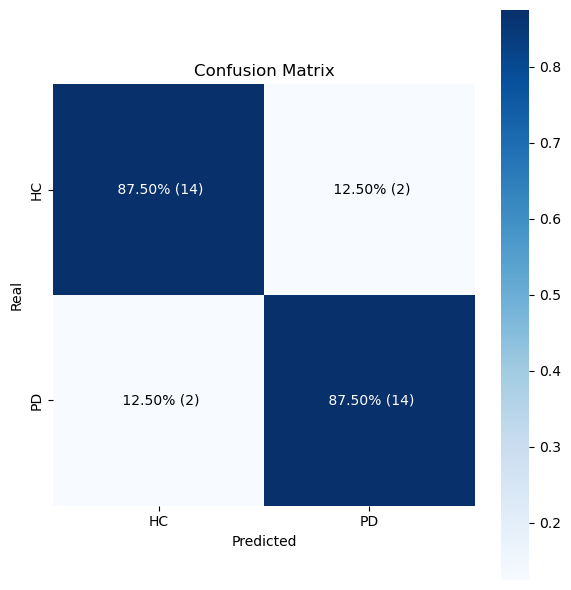

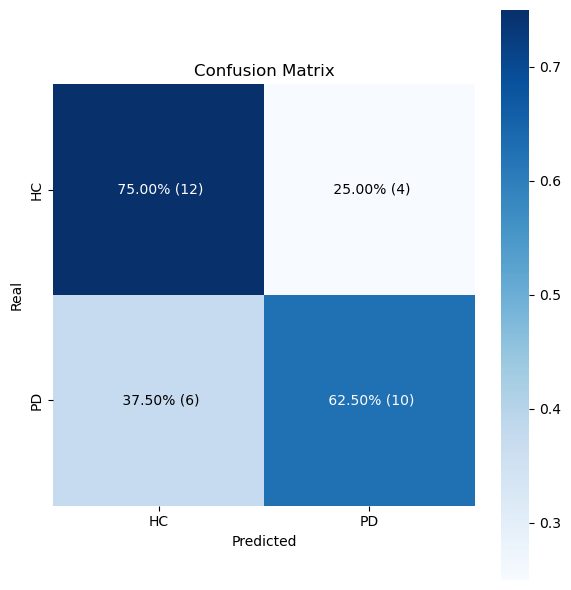

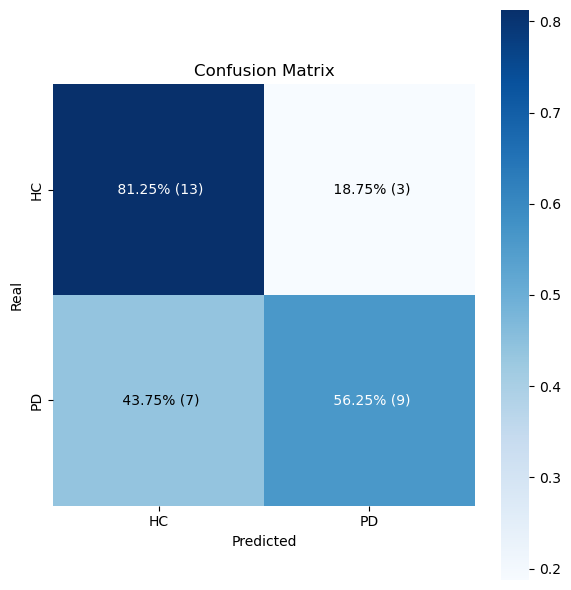

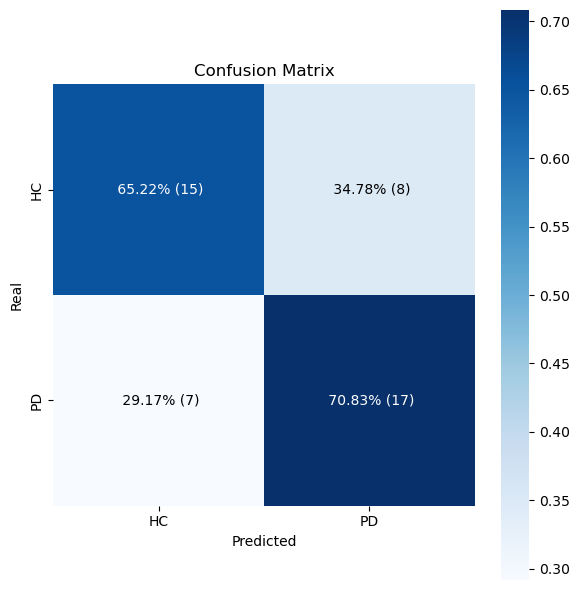

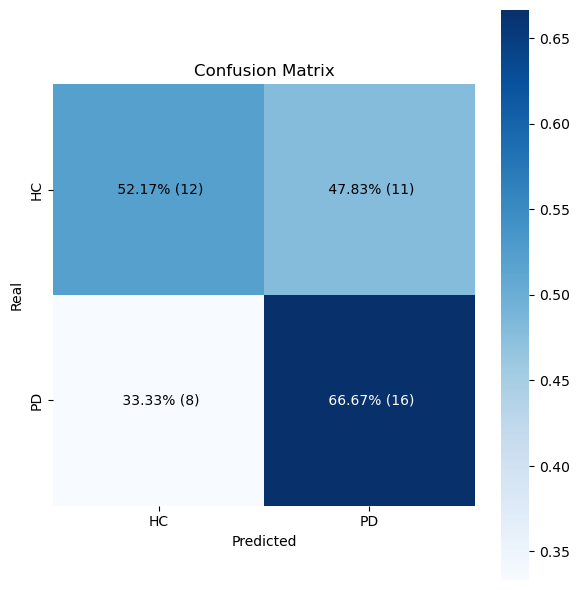

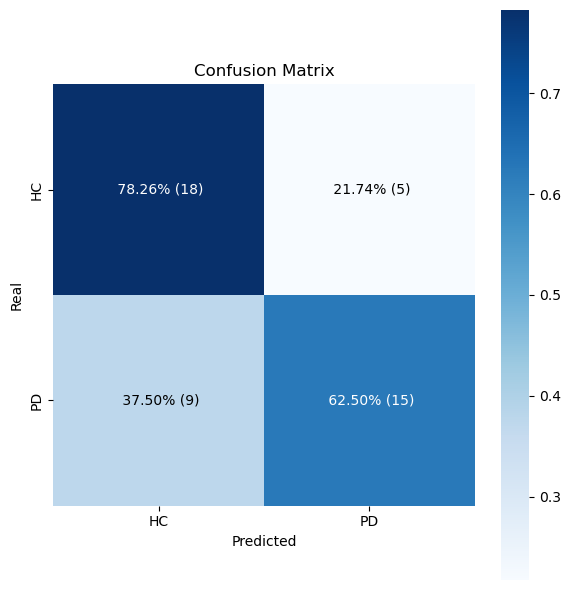

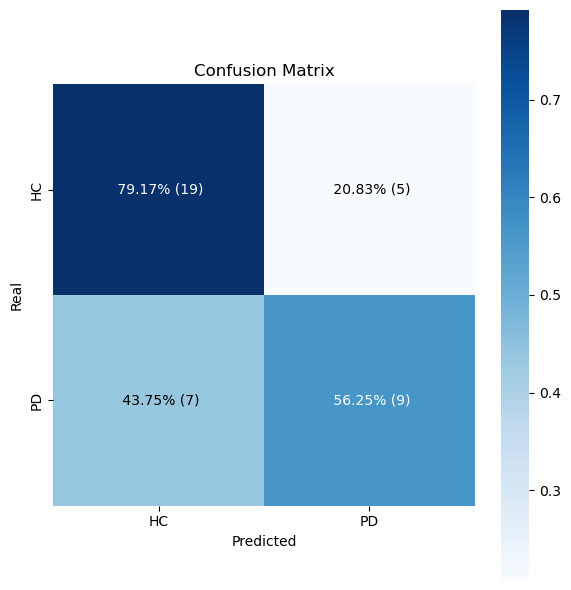

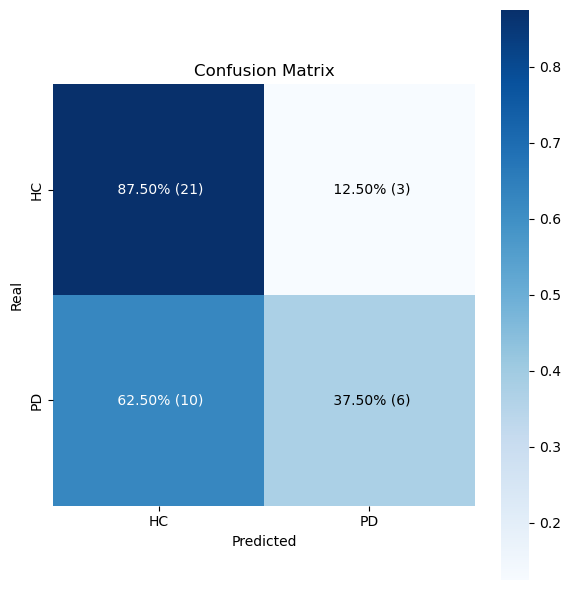

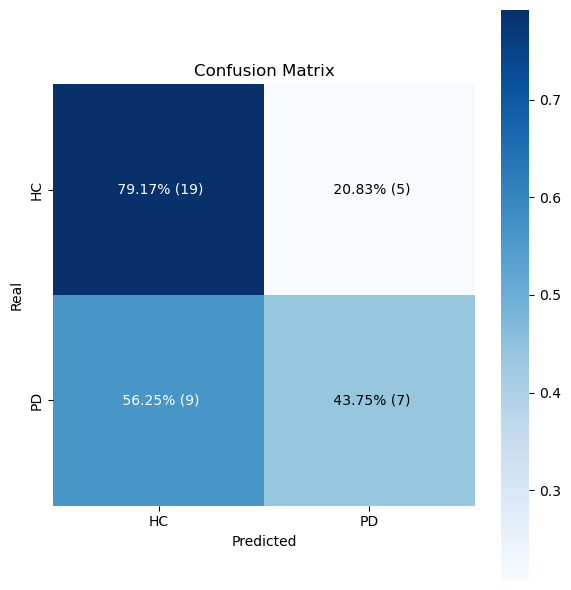

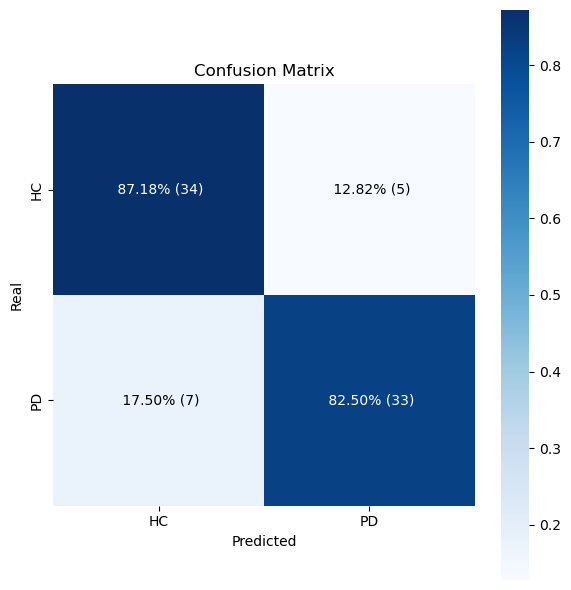

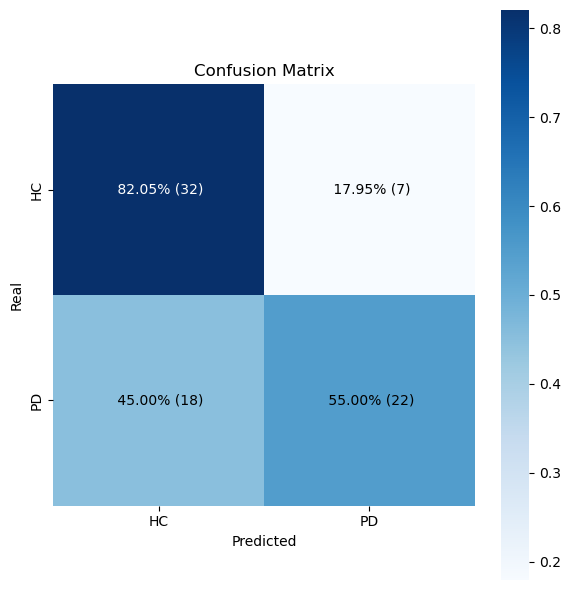

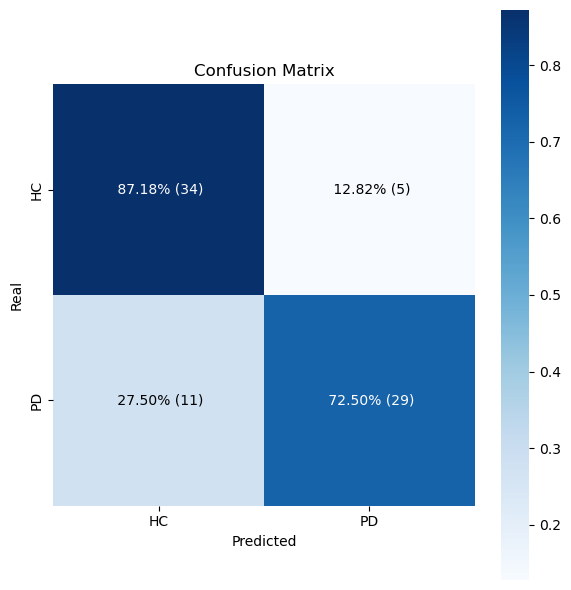

In [10]:
# Load all folds
folds_paths = {
    "CTR_DCL_vs_Park_DCL": "folds/CTR_DCL_vs_Park_DCL_folds.json",
    "CTR_noDCL_vs_Park_noDCL": "folds/CTR_noDCL_vs_Park_noDCL_folds.json",
    "Park_noDCL_vs_Park_DCL": "folds/Park_noDCL_vs_Park_DCL_folds.json",
    "PD_vs_HC": "folds/PD_vs_HC_folds.json"
}

folds_data = {}
for name, path in folds_paths.items():
    with open(path, "r") as f:
        folds_data[name] = json.load(f)

# Load feature sets
features_dict = {
    "articulation": pd.read_csv('features/articulationfeatures.csv').set_index('id'),
    "prosody": pd.read_csv('features/prosodyfeatures.csv').set_index('id'),
    "phonological": pd.read_csv('features/phonologicalfeatures.csv').set_index('id')
}

for fold_name, fold_data in folds_data.items():
    print(f"Running experiments for: {fold_name}")
    
    # Create directory for this fold if it doesn't exist
    os.makedirs(f"results_linear/results_motor_lectura/{fold_name}", exist_ok=True)

    for feat_type, feat_df in features_dict.items():
        print(f" - Feature set: {feat_type}")
        
        results, test_predictions, scores = run_nested_svm_cv(fold_data, feat_df, type='_MOTOR_LECTURA.wav')
        
        results_df = pd.DataFrame(results)
        test_predictions_df = pd.DataFrame(test_predictions)
        scored_df = pd.DataFrame(scores)

        # Save results
        results_df.to_csv(f"results_linear/results_motor_lectura/{fold_name}/{feat_type}_results.csv", index=False)
        test_predictions_df.to_csv(f"results_linear/results_motor_lectura/{fold_name}/{feat_type}_test_predictions.csv", index=False)
        scored_df.to_csv(f"results_linear/results_motor_lectura/{fold_name}/{feat_type}_scores.csv", index=False)

        all_y_true = [x['y_true'] for x in test_predictions]
        all_y_proba = [x['y_proba'] for x in test_predictions]
        all_y_pred = [x['y_pred'] for x in test_predictions]

        os.makedirs(f"results_linear/results_motor_lectura/{fold_name}/plots/", exist_ok=True)

        plot_ROC_curve(all_y_true, all_y_proba, f'results_linear/results_motor_lectura/{fold_name}/plots/roc_curve_{feat_type}.png')
        plot_confusion_matrix(all_y_true, all_y_pred, f'results_linear/results_motor_lectura/{fold_name}/plots/confusion_matrix_{feat_type}.png')
        plot_probability_density(all_y_true, all_y_proba, f'results_linear/results_motor_lectura/{fold_name}/plots/probability_density_{feat_type}.png')

In [11]:
for fold_name, fold_data in folds_data.items():
    print(f"Reading experiments for: {fold_name}")

    for feat_type, feat_df in features_dict.items():
        print(f" - Feature set: {feat_type}")

        # Save results
        results_df = pd.read_csv(f"results_linear/results_motor_lectura/{fold_name}/{feat_type}_results.csv")

        results_test_predictions_df = pd.read_csv(f"results_linear/results_motor_lectura/{fold_name}/{feat_type}_test_predictions.csv")

        for metric in ['accuracy', 'sensitivity', 'specificity', 'f1']:
            mean_val = results_df[metric].mean()
            std_val = results_df[metric].std()
            print(f"{metric.capitalize()}: {100*mean_val:.1f} ± {100*std_val:.1f}")        
        print()

Reading experiments for: CTR_DCL_vs_Park_DCL
 - Feature set: articulation
Accuracy: 88.1 ± 12.1
Sensitivity: 88.3 ± 16.2
Specificity: 88.3 ± 16.2
F1: 87.6 ± 13.7

 - Feature set: prosody
Accuracy: 68.6 ± 20.6
Sensitivity: 63.3 ± 24.7
Specificity: 75.0 ± 27.6
F1: 66.5 ± 20.3

 - Feature set: phonological
Accuracy: 69.0 ± 9.5
Sensitivity: 56.7 ± 14.9
Specificity: 83.3 ± 23.6
F1: 64.1 ± 11.3

Reading experiments for: CTR_noDCL_vs_Park_noDCL
 - Feature set: articulation
Accuracy: 68.0 ± 13.7
Sensitivity: 71.0 ± 10.2
Specificity: 63.0 ± 28.6
F1: 70.4 ± 9.7

 - Feature set: prosody
Accuracy: 59.1 ± 10.9
Sensitivity: 66.0 ± 13.4
Specificity: 50.0 ± 24.2
F1: 62.1 ± 9.5

 - Feature set: phonological
Accuracy: 70.4 ± 10.9
Sensitivity: 63.0 ± 15.7
Specificity: 78.0 ± 22.8
F1: 68.5 ± 11.4

Reading experiments for: Park_noDCL_vs_Park_DCL
 - Feature set: articulation
Accuracy: 70.0 ± 19.0
Sensitivity: 56.7 ± 36.5
Specificity: 80.0 ± 24.5
F1: 56.5 ± 34.4

 - Feature set: prosody
Accuracy: 67.5 ± 14.3

## Early fusion


Running early fusion experiments for: CTR_DCL_vs_Park_DCL
['C006_JJHN_MOTOR_LECTURA.wav', 'C007_RSL_MOTOR_LECTURA.wav', 'C011_JOMG_MOTOR_LECTURA.wav', 'C014_MEMT_MOTOR_LECTURA.wav', 'C020_JEG_MOTOR_LECTURA.wav', 'C033R_JJEE_MOTOR_LECTURA.wav', 'C034_ADV_MOTOR_LECTURA.wav', 'C045_LARE_MOTOR_LECTURA.wav', 'C050_BOLR_MOTOR_LECTURA.wav', 'P002_HJTC_MOTOR_LECTURA.wav', 'P011_CAAA_MOTOR_LECTURA.wav', 'P014_ACE_MOTOR_LECTURA.wav', 'P017_RAL_MOTOR_LECTURA.wav', 'P023_JJEV_MOTOR_LECTURA.wav', 'P024_EAAL_MOTOR_LECTURA.wav', 'P029_JFMG_MOTOR_LECTURA.wav', 'P037_CARS_MOTOR_LECTURA.wav', 'P045_JODG_MOTOR_LECTURA.wav', 'C005_ABV_MOTOR_LECTURA.wav', 'C013_JIHL_MOTOR_LECTURA.wav', 'C019_AEG_MOTOR_LECTURA.wav', 'P006_FAGP_MOTOR_LECTURA.wav', 'P010_EEPC_MOTOR_LECTURA.wav', 'P016_LFLS_MOTOR_LECTURA.wav', 'P036_AVN_MOTOR_LECTURA.wav']
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Initial best C from GridSearch: 0.001
Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
Final bes

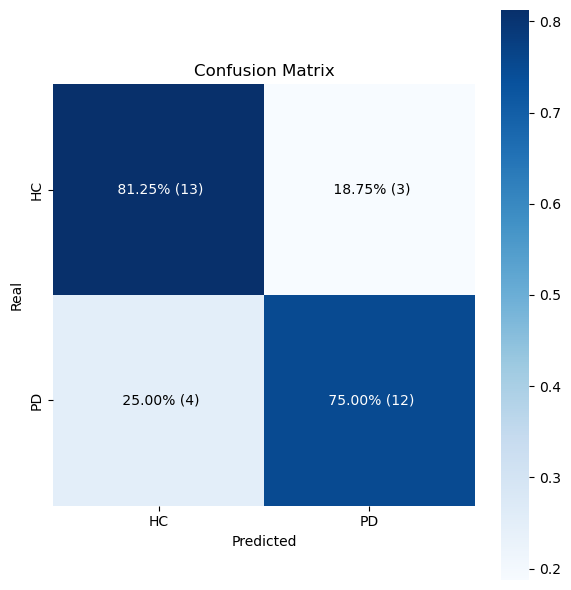

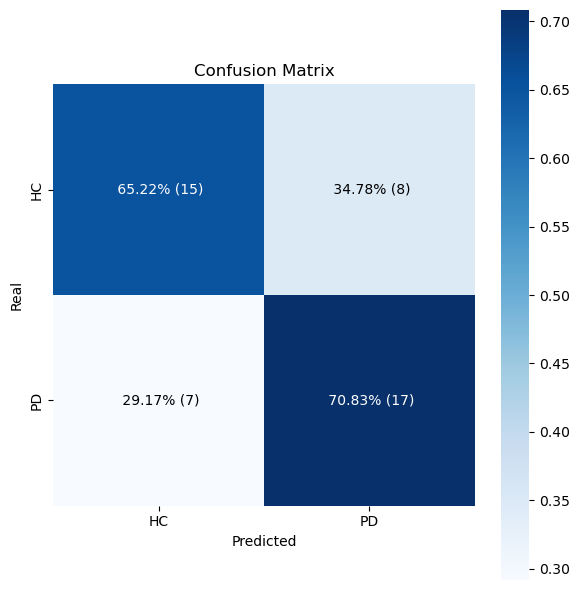

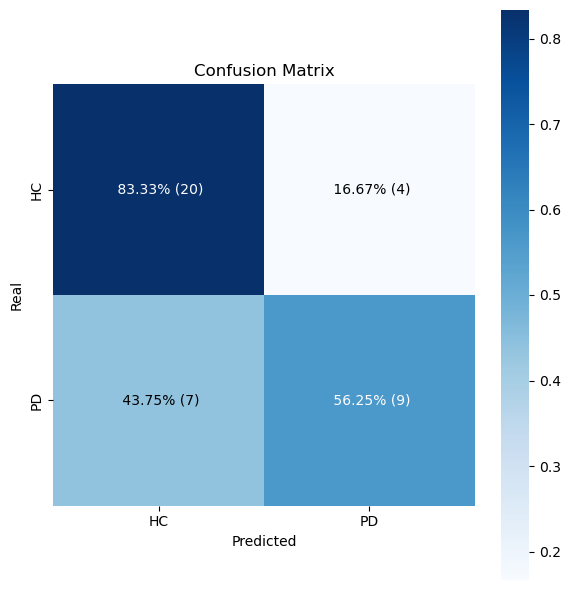

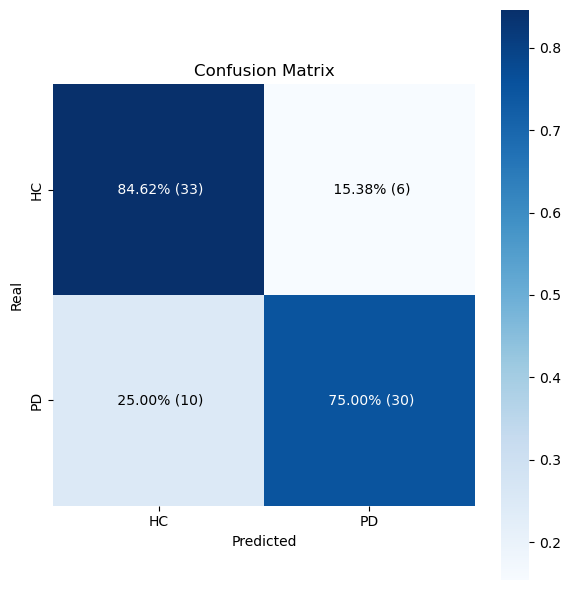

In [12]:
# Create early fusion dataframe by joining on index (id)
features_early_fusion = pd.concat(features_dict.values(), axis=1)

# Run experiments
for fold_name, fold_data in folds_data.items():
    print(f"\nRunning early fusion experiments for: {fold_name}")
    
    # Run nested CV with the concatenated features
    results, test_predictions, scores = run_nested_svm_cv(fold_data, features_early_fusion, type='_MOTOR_LECTURA.wav')
    
    results_df = pd.DataFrame(results)
    test_predictions_df = pd.DataFrame(test_predictions)
    scored_df = pd.DataFrame(scores)

    # Save results
    results_df.to_csv(f"results_linear/results_motor_lectura/{fold_name}/earlyfusion_results.csv", index=False)
    test_predictions_df.to_csv(f"results_linear/results_motor_lectura/{fold_name}/earlyfusion_test_predictions.csv", index=False)
    scored_df.to_csv(f"results_linear/results_motor_lectura/{fold_name}/earlyfusion_scores.csv", index=False)

    all_y_true = [x['y_true'] for x in test_predictions]
    all_y_proba = [x['y_proba'] for x in test_predictions]
    all_y_pred = [x['y_pred'] for x in test_predictions]

    os.makedirs(f"results_linear/results_motor_lectura/{fold_name}/plots/", exist_ok=True)

    plot_ROC_curve(all_y_true, all_y_proba, f'results_linear/results_motor_lectura/{fold_name}/plots/roc_curve_early_fusion.png')
    plot_confusion_matrix(all_y_true, all_y_pred, f'results_linear/results_motor_lectura/{fold_name}/plots/confusion_matrix_early_fusion.png')
    plot_probability_density(all_y_true, all_y_proba, f'results_linear/results_motor_lectura/{fold_name}/plots/probability_density_early_fusion.png')

In [13]:
for fold_name, fold_data in folds_data.items():
    print(f"Reading experiments for early fusion: {fold_name}")

    results_df = pd.read_csv(f"results_linear/results_motor_lectura/{fold_name}/earlyfusion_results.csv")
    
    results_test_predictions_df = pd.read_csv(f"results_linear/results_motor_lectura/{fold_name}/earlyfusion_test_predictions.csv")

    for metric in ['accuracy', 'sensitivity', 'specificity', 'f1']:
        mean_val = results_df[metric].mean()
        std_val = results_df[metric].std()
        print(f"{metric.capitalize()}: {100*mean_val:.1f} ± {100*std_val:.1f}")        
    
    print()

Reading experiments for early fusion: CTR_DCL_vs_Park_DCL
Accuracy: 79.0 ± 15.9
Sensitivity: 76.7 ± 22.4
Specificity: 83.3 ± 23.6
F1: 77.9 ± 16.7

Reading experiments for early fusion: CTR_noDCL_vs_Park_noDCL
Accuracy: 68.2 ± 12.9
Sensitivity: 71.0 ± 10.2
Specificity: 64.0 ± 20.7
F1: 70.2 ± 10.7

Reading experiments for early fusion: Park_noDCL_vs_Park_DCL
Accuracy: 72.5 ± 10.5
Sensitivity: 56.7 ± 27.9
Specificity: 84.0 ± 16.7
F1: 59.9 ± 17.4

Reading experiments for early fusion: PD_vs_HC
Accuracy: 79.8 ± 12.0
Sensitivity: 75.0 ± 15.3
Specificity: 85.0 ± 20.5
F1: 79.0 ± 11.0



## Late fusion

Running experiments for: CTR_DCL_vs_Park_DCL
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Initial best C from GridSearch: 0.1
Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
Final best params from RandomizedSearch:
{'C': 0.04692680899768591, 'kernel': 'linear'}
Final best score: 1.0
--------------- Best Params ------------------
{'C': 0.04692680899768591, 'kernel': 'linear'}
1.0
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Initial best C from GridSearch: 0.1
Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
Final best params from RandomizedSearch:
{'C': 0.04692680899768591, 'kernel': 'linear'}
Final best score: 1.0
--------------- Best Params ------------------
{'C': 0.04692680899768591, 'kernel': 'linear'}
1.0
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Initial best C from GridSearch: 0.1
Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
Final best params from RandomizedSearch:
{'C': 0.0469268

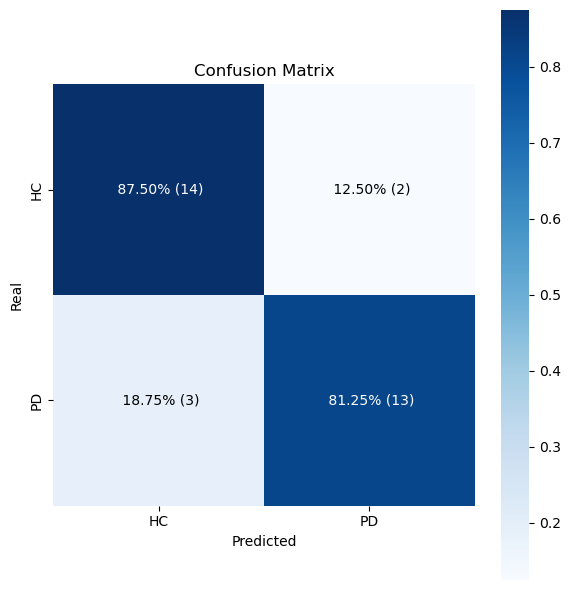

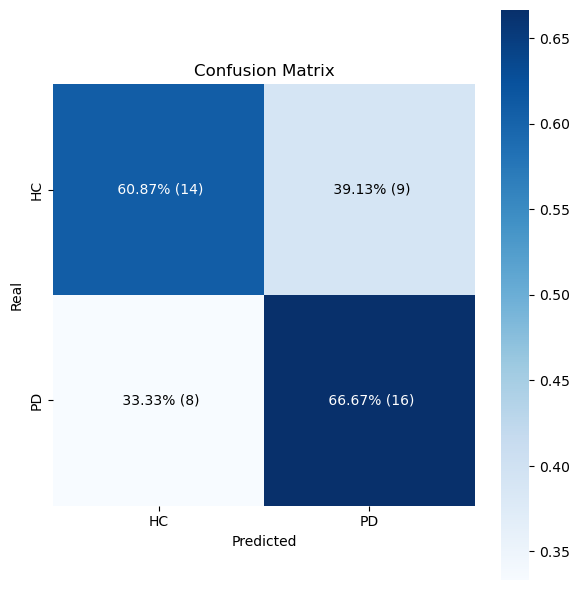

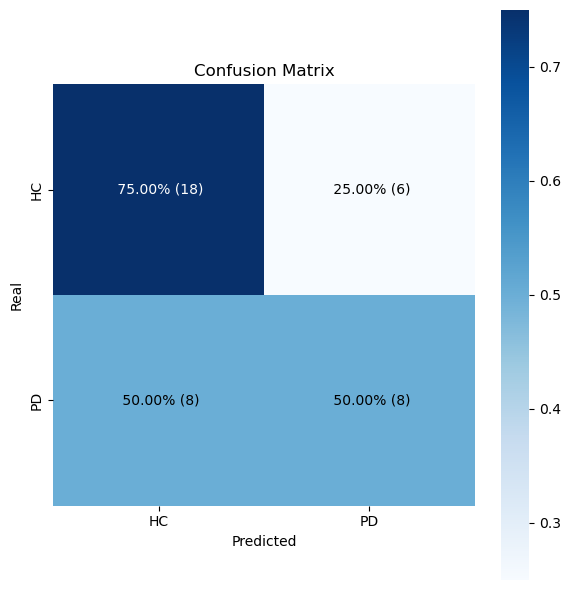

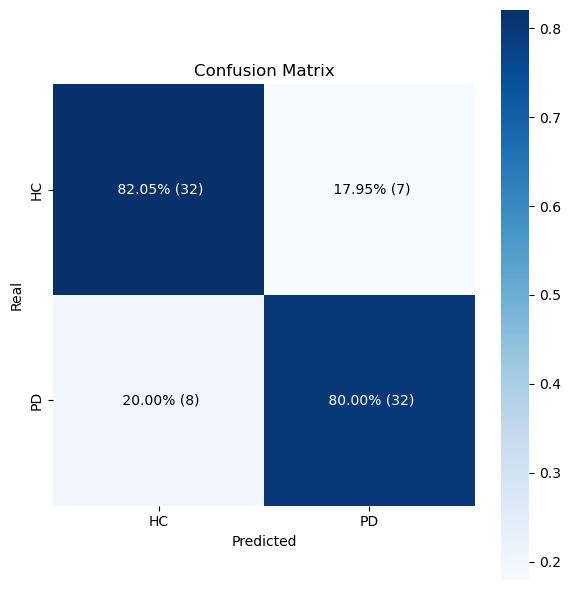

In [14]:
for fold_name, fold_data in folds_data.items():
    print(f"Running experiments for: {fold_name}")

    scores_artic_df = pd.read_csv(f"results_linear/results_motor_lectura/{fold_name}/articulation_scores.csv")
    scores_phon_df = pd.read_csv(f"results_linear/results_motor_lectura/{fold_name}/phonological_scores.csv")
    scores_pros_df = pd.read_csv(f"results_linear/results_motor_lectura/{fold_name}/prosody_scores.csv")
        
    # Select and rename score columns while keeping id, outer_fold, and set_type
    artic_scores = scores_artic_df[['id', 'outer_fold', 'set_type', 'score']].rename(columns={'score': 'artic_score'})
    phon_scores = scores_phon_df[['id', 'outer_fold', 'set_type', 'score']].rename(columns={'score': 'phon_score'})
    pros_scores = scores_pros_df[['id', 'outer_fold', 'set_type', 'score']].rename(columns={'score': 'pros_score'})
        
    # Merge the dataframes
    merged_scores_df = artic_scores.merge(
        phon_scores, 
        on=['id', 'outer_fold', 'set_type']
    ).merge(
        pros_scores,
        on=['id', 'outer_fold', 'set_type']
    )

    results, scores_predictions = run_late_fusion(fold_data, merged_scores_df, type='_MOTOR_LECTURA.wav')
    results_df = pd.DataFrame(results)
    scores_predictions_df = pd.DataFrame(scores_predictions)

    # Save results
    results_df.to_csv(f"results_linear/results_motor_lectura/{fold_name}/latefusion_results.csv", index=False)
    scores_predictions_df.to_csv(f"results_linear/results_motor_lectura/{fold_name}/latefusion_scores.csv", index=False)
    merged_scores_df.to_csv(f"results_linear/results_motor_lectura/{fold_name}/latefusion_scores.csv", index=False)

    all_y_true = [x['y_true'] for x in scores_predictions]
    all_y_proba = [x['y_proba'] for x in scores_predictions]
    all_y_pred = [x['y_pred'] for x in scores_predictions]

    os.makedirs(f"results_linear/results_motor_lectura/{fold_name}/plots/", exist_ok=True)

    plot_ROC_curve(all_y_true, all_y_proba, f'results_linear/results_motor_lectura/{fold_name}/plots/roc_curve_late_fusion.png')
    plot_confusion_matrix(all_y_true, all_y_pred, f'results_linear/results_motor_lectura/{fold_name}/plots/confusion_matrix_late_fusion.png')
    plot_probability_density(all_y_true, all_y_proba, f'results_linear/results_motor_lectura/{fold_name}/plots/probability_density_late_fusion.png')

In [15]:
for fold_name, fold_data in folds_data.items():
    print(f"Lectura experiments for late fusion: {fold_name}")

    results_df = pd.read_csv(f"results_linear/results_motor_lectura/{fold_name}/latefusion_results.csv")

    for metric in ['accuracy', 'sensitivity', 'specificity', 'f1']:
        mean_val = results_df[metric].mean()
        std_val = results_df[metric].std()
        print(f"{metric.capitalize()}: {100*mean_val:.1f} ± {100*std_val:.1f}")        
    
    print()

Lectura experiments for late fusion: CTR_DCL_vs_Park_DCL
Accuracy: 85.2 ± 14.3
Sensitivity: 83.3 ± 23.6
Specificity: 88.3 ± 16.2
F1: 83.8 ± 16.7

Lectura experiments for late fusion: CTR_noDCL_vs_Park_noDCL
Accuracy: 63.6 ± 13.4
Sensitivity: 67.0 ± 9.7
Specificity: 58.0 ± 30.1
F1: 65.9 ± 7.3

Lectura experiments for late fusion: Park_noDCL_vs_Park_DCL
Accuracy: 65.0 ± 5.6
Sensitivity: 51.7 ± 31.4
Specificity: 76.0 ± 26.1
F1: 50.8 ± 11.5

Lectura experiments for late fusion: PD_vs_HC
Accuracy: 81.0 ± 11.7
Sensitivity: 80.0 ± 11.2
Specificity: 82.1 ± 14.1
F1: 81.1 ± 11.3

